# 1- Load data

In [168]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import date
from sklearn import preprocessing
from IPython.display import Image
from IPython.core.display import HTML, display
import PIL.Image as pImage
import requests
from io import BytesIO
from textblob import TextBlob
import re
from nltk.corpus import stopwords
#from nltk.tokenize  import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import glob
import csv
from wordcloud import WordCloud, STOPWORDS




In [135]:
path ='socialgood_data/all_industries' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
industries = []
with open('Industries.csv', 'r') as csvfile:
        i_reader = csv.reader(csvfile, delimiter=',')        
        for row in i_reader:
            industries.append(row[0])
                    
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0, parse_dates=['date'])
    #df['search_term'] = "".join(file_.split('/')[-1].split('.')[0].split('_')[1:])
    df['Industry_index'] = int(file_.split('/')[-1].split('.')[0].split('_')[0])
    df['search_term'] = industries[int(file_.split('/')[-1].split('.')[0].split('_')[0]) -1]
    list_.append(df)
all_tweets = pd.concat(list_).drop_duplicates().reset_index(drop=True)
all_tweets.head(2)

,date,favorites,geo,hashtags,id,mentions,permalink,retweets,text,username,Industry_index,search_term
0,2017-06-14 01:00:07,0,NaN,#AI #OnlinePublishing #NYTimes,874853937043603456,NaN,https://twitter.com/qaiser76/status/8748539370...,0,New York Times Deploys Troll-Blocking AI to Ex...,qaiser76,100,Online Publishing
1,2017-03-27 12:00:31,0,NaN,#Publishers #AI #Sales #onlinepublishing,846391492558147585,@RealWilsonLee,https://twitter.com/boomtrain/status/846391492...,0,Why #Publishers want #AI Solutions: A perspect...,boomtrain,100,Online Publishing


In [136]:
all_tweets.describe()

,Industry_index
count,246472.000000
mean,65.359891
std,39.953893
min,1.000000
25%,34.000000
50%,66.000000
75%,95.000000
max,148.000000


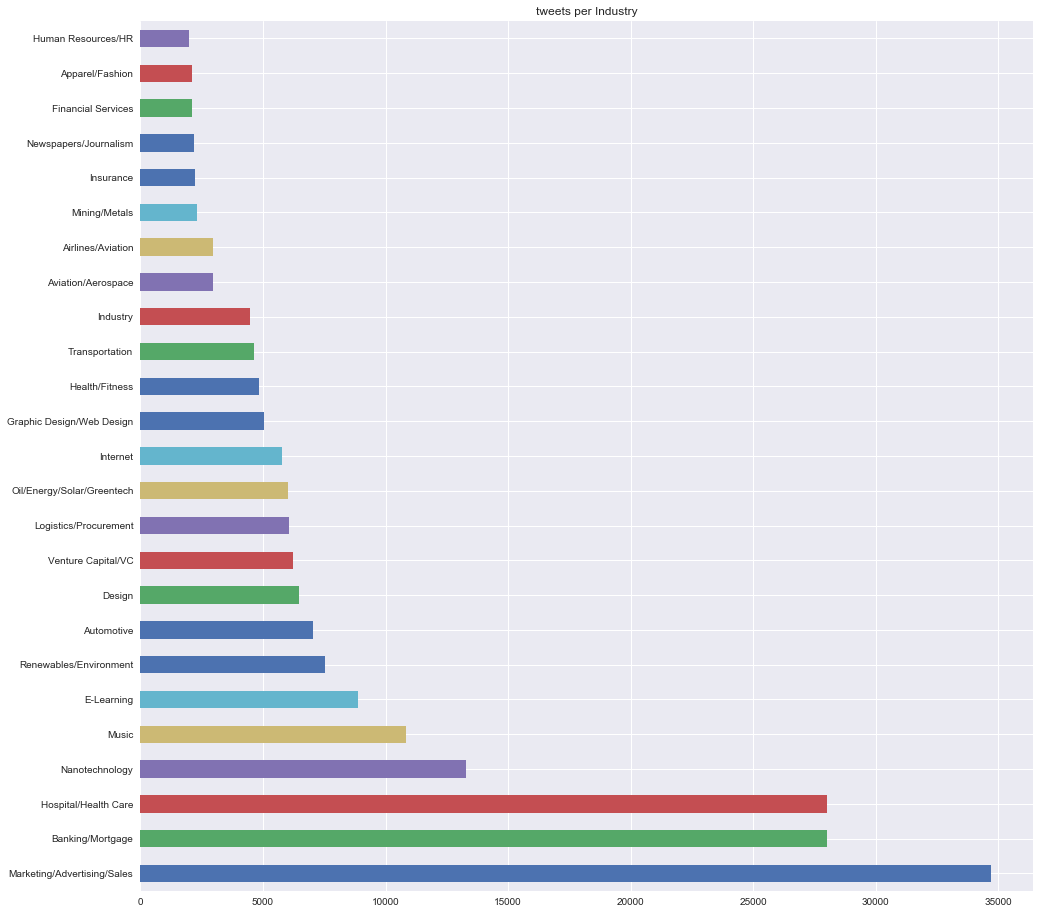

In [137]:
plt.rcParams["figure.figsize"] = [16,16]
all_tweets.search_term.value_counts().nlargest(25).plot(kind='barh',title="tweets per Industry");


In [182]:
top_Industries = list(reversed(list(all_tweets.Industry_index.value_counts().nlargest(50).keys())))

In [139]:
#all_tweets = pd.read_csv('agriculture_AI.csv', parse_dates=['date'])
all_tweets.drop(['geo'], axis = 1, inplace=True)
#all_tweets.head(8)

# 2 - Preprocess data (missing values, LabelEncoding, )

In [140]:
#missing data
total = all_tweets.isnull().sum().sort_values(ascending=False)
percent = (all_tweets.isnull().sum()/all_tweets.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
#missing_data.head(20)

In [141]:
all_tweets = all_tweets.fillna('')
all_tweets['hashtags_list'] = all_tweets.hashtags.str.lower().apply(lambda x: x.split('#'))
all_tweets['hashtags_list'] = all_tweets[['hashtags_list']].applymap(lambda x: list(filter(None, x)))
all_tweets['mentions_list'] = all_tweets.mentions.str.lower().apply(lambda x: x.split('@'))
all_tweets['mentions_list'] = all_tweets[['mentions_list']].applymap(lambda x: list(filter(None, x)))
 

all_tweets["count_hashtags"] = all_tweets[['hashtags']].applymap(lambda x: str.count(x, '#'))
all_tweets["count_mentions"] = all_tweets[['mentions']].applymap(lambda x: str.count(x, '@'))

In [142]:
all_tweets.hashtags_list[0]

['ai ', 'onlinepublishing ', 'nytimes']

In [143]:
lbl = preprocessing.LabelEncoder()
all_tweets['username_id'] = lbl.fit_transform(all_tweets['username'])
all_tweets.head(5)

list_of_original_tweets = [element for element in all_tweets['text'].values if element.startswith('RT')]
print(len(list_of_original_tweets))
list_of_original_tweets[0]

23757


"RT @pivotaliQ : @pivotaliQ 's @A_J_Burgess discusses the impact of #RPA & #AI on the #outsourcing sector with @kitburden partner and head of #Technology Sector at @DLA_Piper - #ArtificialInteligence #robotic #process #automation https://www. youtube.com/watch?v=fzeF9N WPWlw …"

In [144]:
def tweet_clean_and_stem(text):
    stopword_set = set(stopwords.words("english"))
    stopword_set.add('…')
    ps = PorterStemmer()

    tweet_c = ' '.join([ps.stem(word) for word in text.split(' ') if(len(word) > 0 and word[0] != '@' and word[0] != '#' 
                                                            and word not in stopword_set)])
    return tweet_c

def strip_links(text):
    link_regex    = re.compile('((https?):((// )|(\\\\ ))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], '')    
    return text 

def strip_retweetinfo(text):
    return re.sub('RT: \((\w+)\)', '', text)

In [145]:
all_tweets['clean_text'] = all_tweets[['text']].applymap(tweet_clean_and_stem).applymap(strip_links).applymap(strip_retweetinfo)


all_tweets.head()

,date,favorites,hashtags,id,mentions,permalink,retweets,text,username,Industry_index,search_term,hashtags_list,mentions_list,count_hashtags,count_mentions,username_id,clean_text
0,2017-06-14 01:00:07,0,#AI #OnlinePublishing #NYTimes,874853937043603456,,https://twitter.com/qaiser76/status/8748539370...,0,New York Times Deploys Troll-Blocking AI to Ex...,qaiser76,100,Online Publishing,"[ai , onlinepublishing , nytimes]",[],3,0,38279,new york time deploy troll-block AI expand com...
1,2017-03-27 12:00:31,0,#Publishers #AI #Sales #onlinepublishing,846391492558147585,@RealWilsonLee,https://twitter.com/boomtrain/status/846391492...,0,Why #Publishers want #AI Solutions: A perspect...,boomtrain,100,Online Publishing,"[publishers , ai , sales , onlinepublishing]",[realwilsonlee],4,1,26272,whi want solutions: A perspect : pic.twitter....
2,2017-03-23 05:46:06,0,#ArtificialIntelligence #Recommendation #Onlin...,844847716777676802,,https://twitter.com/_gopinathg/status/84484771...,0,How #ArtificialIntelligence #Recommendation en...,_gopinathg,100,Online Publishing,"[artificialintelligence , recommendation , onl...",[],7,0,23927,how engin chang pic.twitter.com/soypnqpxdj
3,2017-03-22 09:39:01,0,#ArtificialIntelligence #Recommendation #Onlin...,844543942788075520,,https://twitter.com/_gopinathg/status/84454394...,0,How #ArtificialIntelligence #Recommendation en...,_gopinathg,100,Online Publishing,"[artificialintelligence , recommendation , onl...",[],7,0,23927,how engin chang pic.twitter.com/kucnwfv3v1
4,2017-02-09 11:17:01,1,#Publishers #AI #Sales #onlinepublishing,829725800941355008,@RealWilsonLee,https://twitter.com/boomtrain/status/829725800...,0,Why #Publishers want #AI Solutions: A perspect...,boomtrain,100,Online Publishing,"[publishers , ai , sales , onlinepublishing]",[realwilsonlee],4,1,26272,whi want solutions: A perspect :


In [146]:
all_tweets.describe()

,favorites,id,retweets,Industry_index,count_hashtags,count_mentions,username_id
count,246472.000000,2.464720e+05,246472.000000,246472.000000,246472.000000,246472.000000,246472.000000
mean,2.624351,8.956748e+17,2.785959,65.359891,8.249959,0.600385,20257.400934
std,16.337689,1.050757e+17,16.497403,39.953893,5.718530,1.292984,12499.843456
min,0.000000,4.182328e+17,0.000000,1.000000,2.000000,0.000000,0.000000
25%,0.000000,8.802262e+17,0.000000,34.000000,4.000000,0.000000,9790.750000
50%,0.000000,9.358471e+17,0.000000,66.000000,7.000000,0.000000,20259.000000
75%,2.000000,9.609419e+17,2.000000,95.000000,11.000000,1.000000,30753.000000
max,2789.000000,9.798702e+17,2479.000000,148.000000,262.000000,19.000000,43669.000000



# 2- Analyse each column: 



In [147]:
#plt.rcParams["figure.figsize"] = [16,9]
#sns.distplot(all_tweets['favorites']);

In [148]:
all_tweets['favorites'].describe()

count    246472.000000
mean          2.624351
std          16.337689
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max        2789.000000
Name: favorites, dtype: float64

**The mean favorite count is : 2.6**

In [149]:
#sns.distplot(all_tweets['retweets']);

In [150]:
all_tweets['retweets'].describe()

count    246472.000000
mean          2.785959
std          16.497403
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max        2479.000000
Name: retweets, dtype: float64

**The mean retweets count is : 2.7**

In [151]:
#sns.distplot(all_tweets['count_mentions']);

In [152]:
all_tweets['count_mentions'].describe()

count    246472.000000
mean          0.600385
std           1.292984
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: count_mentions, dtype: float64

**The mean mentions count is : 0.6**

In [153]:
#sns.distplot(all_tweets['count_hashtags']);

In [154]:
all_tweets['count_hashtags'].describe()

count    246472.000000
mean          8.249959
std           5.718530
min           2.000000
25%           4.000000
50%           7.000000
75%          11.000000
max         262.000000
Name: count_hashtags, dtype: float64

**The mean hashtag count is : 8**

In [155]:
#sns.distplot(all_tweets['username_id']);
#sns.countplot(x="username_id", data=all_tweets, orient='v');

In [156]:
all_tweets['username_id'].describe()

count    246472.000000
mean      20257.400934
std       12499.843456
min           0.000000
25%        9790.750000
50%       20259.000000
75%       30753.000000
max       43669.000000
Name: username_id, dtype: float64

**The unique members tweeted are : 43669**

# 3 - See correlations among 2 variables

**Does the retweet count increases by number of mentions or hashtags ??**

* Obviously, for all tweets with >4 mentions or >10 hashtags, we dont see a high number for re-tweet count in below charts.


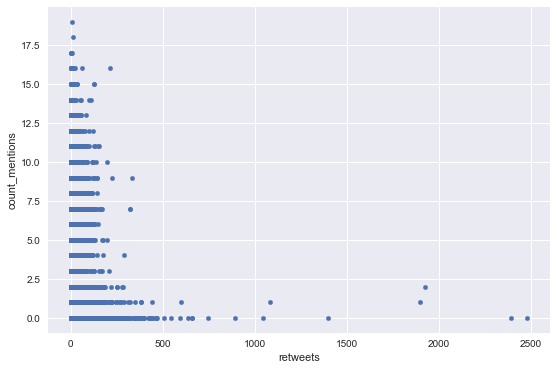

In [157]:
#scatter plot favorites/retweets
var = 'retweets'
data = pd.concat([all_tweets['count_mentions'], all_tweets[var]], axis=1)
plt.rcParams["figure.figsize"] = [9,6]
data.plot.scatter(x=var, y='count_mentions');

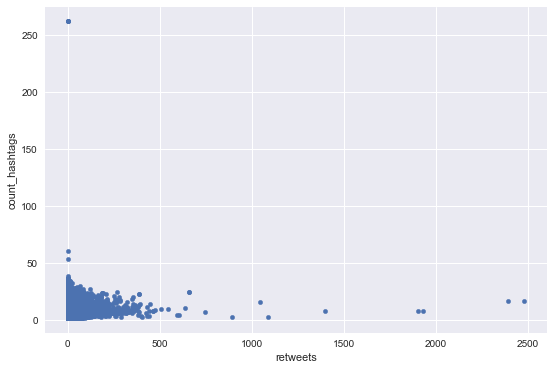

In [158]:
#scatter plot favorites/retweets
var = 'retweets'
data = pd.concat([all_tweets['count_hashtags'], all_tweets[var]], axis=1)
data.plot.scatter(x=var, y='count_hashtags');

**Does the favorites count increases by number of mentions or hashtags ??**

* Obviously, for all tweets with >4 mentions or >10 hashtags, we dont see a high number for favorites count in below charts.


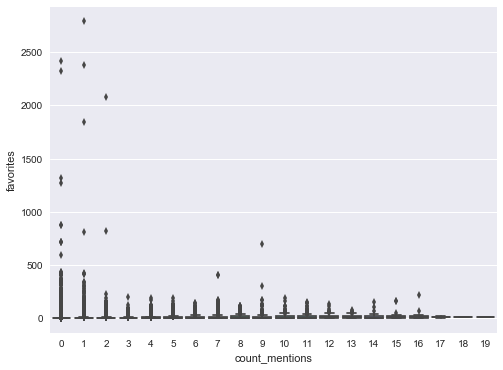

In [159]:
#box plot overallqual/saleprice
var = 'count_mentions'
data = pd.concat([all_tweets['favorites'], all_tweets[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="favorites", data=data)

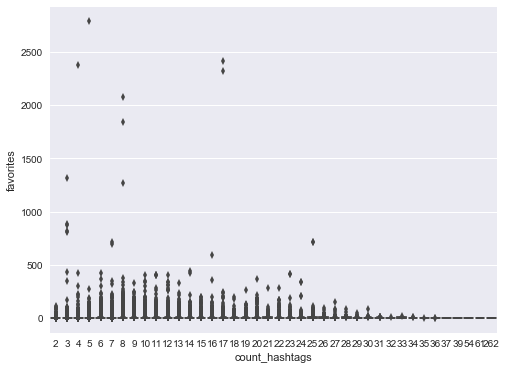

In [160]:
#box plot overallqual/saleprice
var = 'count_hashtags'
data = pd.concat([all_tweets['favorites'], all_tweets[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="favorites", data=data)

**Lets see the correlation among all columns**

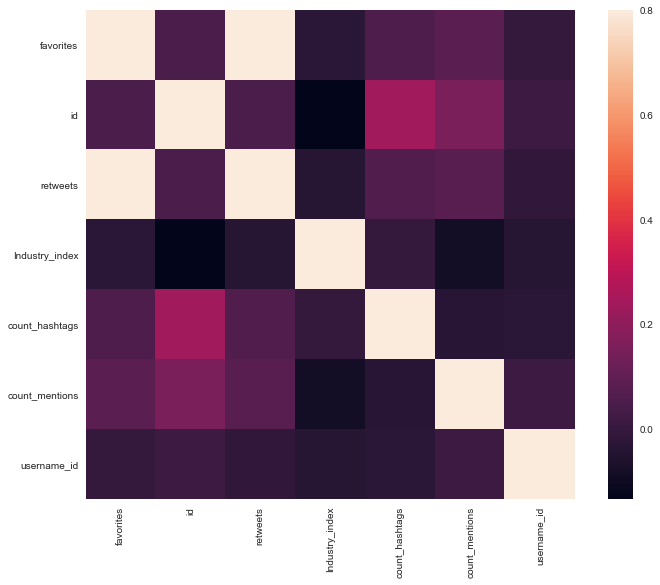

In [161]:
#correlation matrix
corrmat = all_tweets.corr()
plt.rcParams["figure.figsize"] = [16,9]
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);


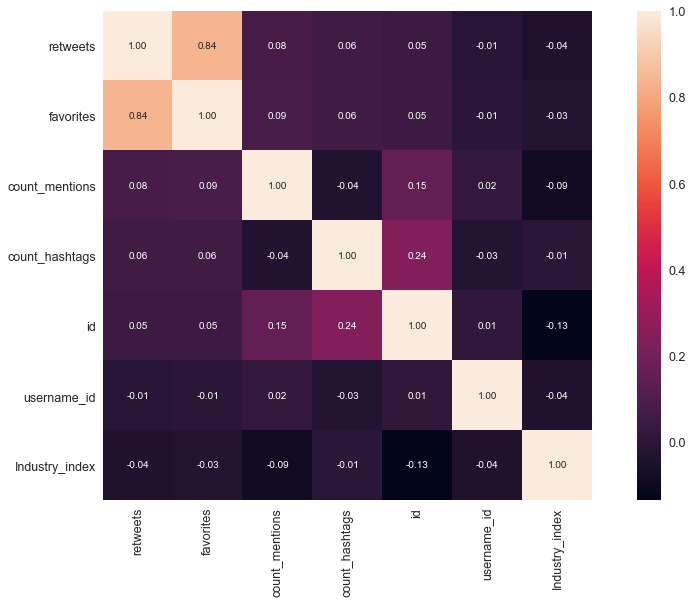

In [162]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'retweets')['retweets'].index
cm = np.corrcoef(all_tweets[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


**Observations:**
1. 75% correlation between retweet count and favorites count. It makes perfect sense as more people will like if the tweet reach more people.
2. This is very interesting to see 23% correlation between tweet_id, hashtag_count. If we see the below correlation between id and count_hashtags, we can see small tendency of using more hastags with increase in id value. This tells that people are using more hastags in recent time than before, makes perfect sense.

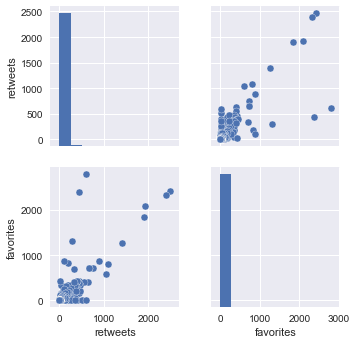

In [163]:
#scatterplot
sns.set()
cols = ['retweets',  'favorites']
sns.pairplot(all_tweets[cols], size = 2.5)
plt.show();

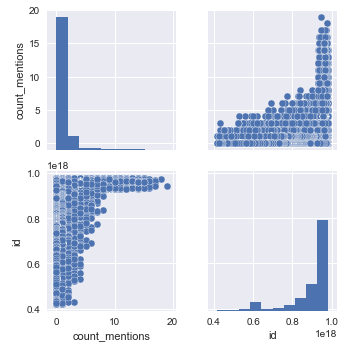

In [164]:
#scatterplot
sns.set()
cols = ['count_mentions', 'id']
sns.pairplot(all_tweets[cols], size = 2.5)
plt.show();


# 4 - Most Influential people

In [193]:
def grid_display(list_of_images, list_of_titles=[], list_of_xlabels=[], list_of_ylabels=[],
                 list_of_profile_urls=[], no_of_columns=6, figsize=(14,14)):

    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        response = requests.get(list_of_images[i])
        img = pImage.open(BytesIO(response.content))
        plt.imshow(np.array(img))
        plt.axis('off')
        plt.title('Influential people with more tweets on AI')
        #plt.axis.Axis.set_url(list_of_profile_urls[i])
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i] + '\n\n' + list_of_ylabels[i] + '\n\n' +list_of_xlabels[i],
                      fontsize = 10, verticalalignment='baseline')

In [194]:
def display_influential(df):
    #print("profile_name - no_of_tweets - link_to_profile")
    list_of_images = []
    list_of_titles = []
    list_of_xlabels = []
    list_of_ylabels = []
    list_of_profile_urls = []
    for index, row in df.iterrows():
        p_url = 'https://twitter.com/'+ row['username'] +'/profile_image?size=original'
        list_of_images.append(p_url)
        list_of_titles.append(row['search_term'])
        list_of_xlabels.append(row['username'])
        list_of_ylabels.append(str(row['Size']) + ' tweets on AI')
        list_of_profile_urls.append("https://twitter.com/" + row['username'] )
        
    grid_display(list_of_images, list_of_titles, list_of_xlabels, list_of_ylabels, list_of_profile_urls)

In [195]:
#top_Industries
#all_tweets[all_tweets.Industry_index == 57]

/Users/anveshtummala/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


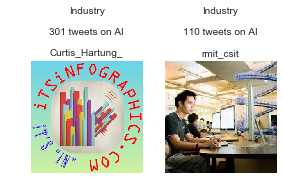

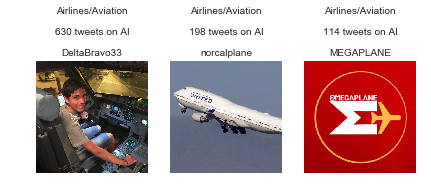

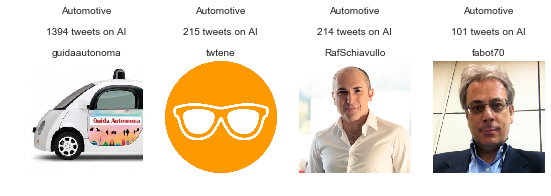

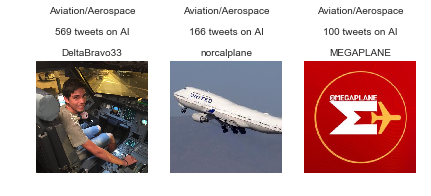

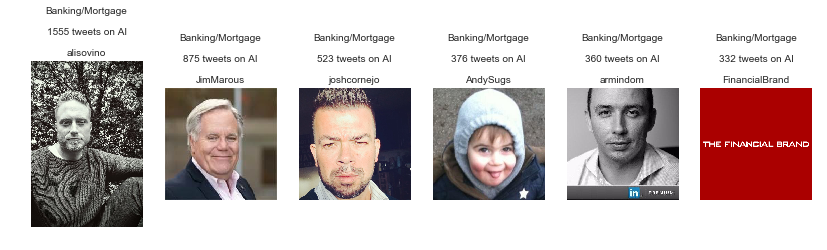

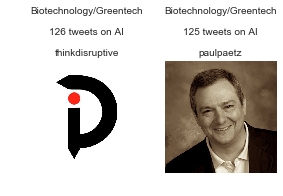

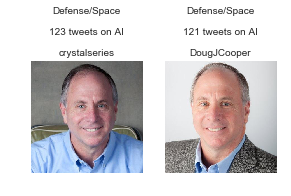

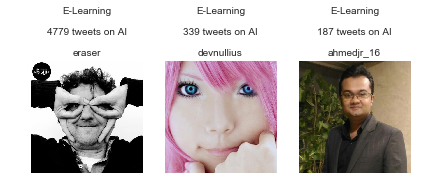

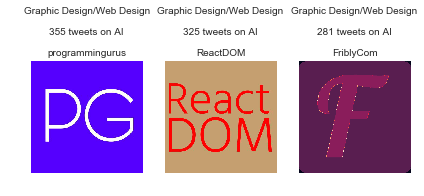

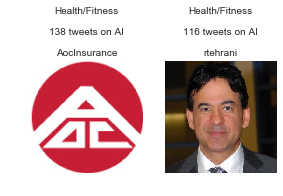

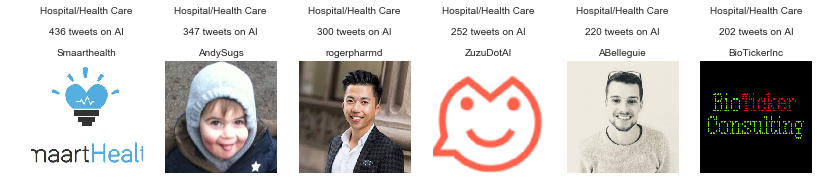

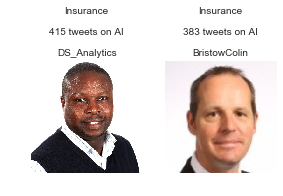

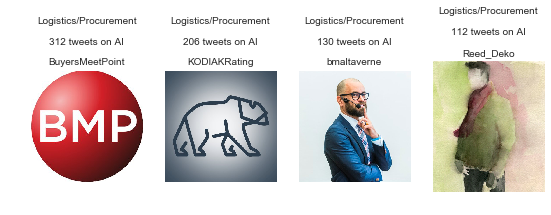

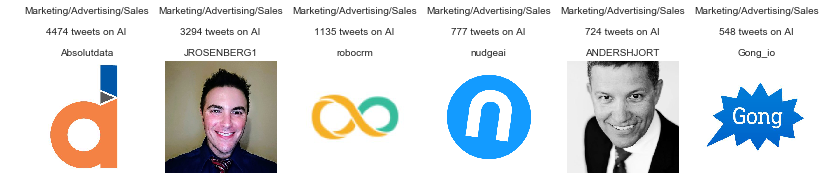

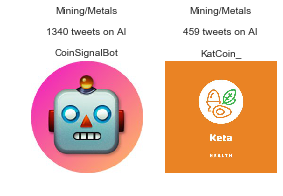

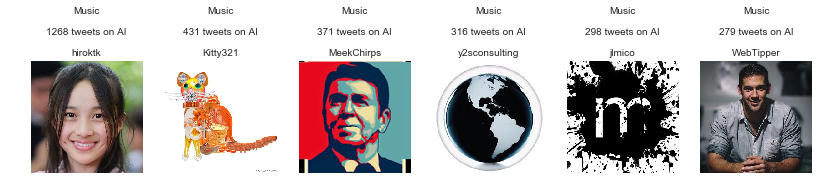

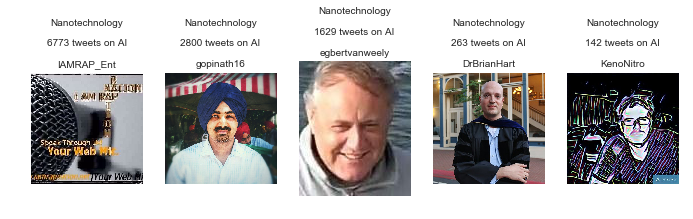

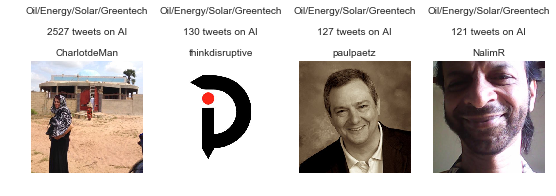

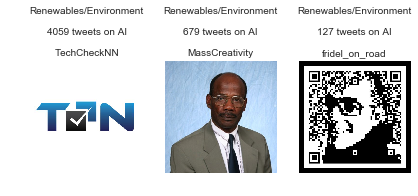

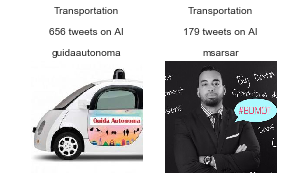

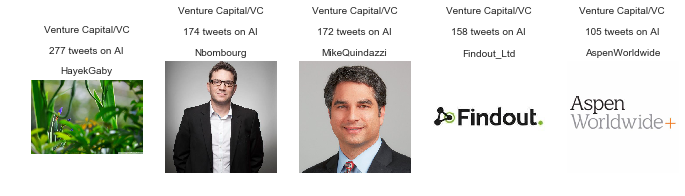

In [202]:

plt.rcParams["figure.figsize"] = [16,9]

for i in range(1, 149): #top_Industries:
    if i < 104 or i > 104:
        groups = all_tweets[all_tweets.Industry_index == i].copy(deep=True)

        if len(groups.index) > 1:     
            groups = groups[['username_id', 'username', 'search_term']]
            groups = groups.groupby(['username_id', 'username', 'search_term']).size().reset_index(name='Size')
            groups = groups.sort_values(by=['Size'], ascending=False).nlargest(6, 'Size')
            groups = groups[groups['Size'] >= 100]
            if len(groups.index) > 1:
                display_influential(groups)


# 5 - Analyse Co-occurring hashtags

Lets Analyse co-occurring hastags that we might want to include in our data collection.(If related to socialgood topic)

In [203]:
 pd.Series(' '.join(all_tweets['hashtags']).lower().split('#')).value_counts()[:15]


ai                         249266
iot                         57001
bigdata                     49763
tech                        46082
machinelearning             41009
healthcare                  38257
fintech                     35463
artificialintelligence      32695
banking                     29862
sales                       27632
ml                          25228
technology                  20153
marketing                   19778
blockchain                  17662
robotics                    15837
dtype: int64

In [204]:
def sentimentSplit(sentiment):
    if sentiment < -0.1:
        sentiment = 'NEGATIVE'
    elif sentiment >=-0.1 and sentiment <= 0.1:
        sentiment = 'NEUTRAL'
    else:
        sentiment = 'POSITIVE'
    return sentiment

sid = SentimentIntensityAnalyzer()

all_tweets = all_tweets.copy(deep=True)
all_tweets['sentiment_compound_polarity']=all_tweets.clean_text.apply(lambda x:sid.polarity_scores(x)['compound'])
all_tweets['sentiment_neutral']=all_tweets.clean_text.apply(lambda x:sid.polarity_scores(x)['neu'])
all_tweets['sentiment_negative']=all_tweets.clean_text.apply(lambda x:sid.polarity_scores(x)['neg'])
all_tweets['sentiment_pos']=all_tweets.clean_text.apply(lambda x:sid.polarity_scores(x)['pos'])
all_tweets['sentiment_type']= all_tweets['sentiment_compound_polarity'].apply(lambda x: sentimentSplit(x))
all_tweets.head()

,date,favorites,hashtags,id,mentions,permalink,retweets,text,username,Industry_index,...,mentions_list,count_hashtags,count_mentions,username_id,clean_text,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type
0,2017-06-14 01:00:07,0,#AI #OnlinePublishing #NYTimes,874853937043603456,,https://twitter.com/qaiser76/status/8748539370...,0,New York Times Deploys Troll-Blocking AI to Ex...,qaiser76,100,...,[],3,0,38279,new york time deploy troll-block AI expand com...,0.3182,0.777,0.0,0.223,POSITIVE
1,2017-03-27 12:00:31,0,#Publishers #AI #Sales #onlinepublishing,846391492558147585,@RealWilsonLee,https://twitter.com/boomtrain/status/846391492...,0,Why #Publishers want #AI Solutions: A perspect...,boomtrain,100,...,[realwilsonlee],4,1,26272,whi want solutions: A perspect : pic.twitter....,0.2500,0.500,0.0,0.500,POSITIVE
2,2017-03-23 05:46:06,0,#ArtificialIntelligence #Recommendation #Onlin...,844847716777676802,,https://twitter.com/_gopinathg/status/84484771...,0,How #ArtificialIntelligence #Recommendation en...,_gopinathg,100,...,[],7,0,23927,how engin chang pic.twitter.com/soypnqpxdj,0.0000,1.000,0.0,0.000,NEUTRAL
3,2017-03-22 09:39:01,0,#ArtificialIntelligence #Recommendation #Onlin...,844543942788075520,,https://twitter.com/_gopinathg/status/84454394...,0,How #ArtificialIntelligence #Recommendation en...,_gopinathg,100,...,[],7,0,23927,how engin chang pic.twitter.com/kucnwfv3v1,0.0000,1.000,0.0,0.000,NEUTRAL
4,2017-02-09 11:17:01,1,#Publishers #AI #Sales #onlinepublishing,829725800941355008,@RealWilsonLee,https://twitter.com/boomtrain/status/829725800...,0,Why #Publishers want #AI Solutions: A perspect...,boomtrain,100,...,[realwilsonlee],4,1,26272,whi want solutions: A perspect :,0.2500,0.400,0.0,0.600,POSITIVE


In [205]:
#Create sentiment range
#def sentimentSplit(sentiment):
#    if sentiment < -.33:
#        sentiment = -1
#    elif sentiment >=-.33 and sentiment <= .33:
#        sentiment = 0
#    else:
#        sentiment = 1
#    return sentiment
#all_tweets['sentimentRange'] = all_tweets['sentiment'].apply(lambda x: sentimentSplit(x))

#all_tweets['sentiment'] = all_tweets[['clean_text']].applymap(lambda x: TextBlob(x).sentiment.polarity)
#sns.countplot(x="sentimentRange", data=all_tweets);
# all_tweets[all_tweets['sentiment'] >=0].sort_values(by=['sentiment'], ascending=False).head(2)[['clean_text']]
# all_tweets[all_tweets['sentiment'] <0].sort_values(by=['sentiment'], ascending=True).head(2)[['clean_text']]

In [206]:
all_tweets[all_tweets['sentiment_compound_polarity'] >=0].sort_values(by=['sentiment_compound_polarity'], ascending=False).head(2)[['date','text','sentiment_compound_polarity', 'username']]

,date,text,sentiment_compound_polarity,username
188645,2017-12-22 12:15:04,"The Clozer app is coming, with #NLP , #AI , & ...",0.9770,ClozerAI
214245,2018-02-07 19:29:39,Good bye New Orleans and thank you! Nice place...,0.9686,DanMagazzeni


In [207]:
all_tweets[all_tweets['sentiment_compound_polarity'] <0].sort_values(by=['sentiment_compound_polarity'], ascending=True).head(2)[['date','clean_text','sentiment_compound_polarity','username']]

,date,clean_text,sentiment_compound_polarity,username
83926,2018-02-25 17:06:04,we'r verg creat autonom weapons that kill with...,-0.9575,vtchakarova
224674,2017-11-14 15:55:07,thi team creat nanoparticl heat & kill cancer ...,-0.9493,PghLifeSciences


In [208]:
all_tweets['year'] = all_tweets['date'].dt.year
all_tweets['month'] = all_tweets['date'].dt.month
all_tweets['month_name'] = all_tweets['date'].dt.strftime('%b')
all_tweets['day'] = all_tweets['date'].dt.day

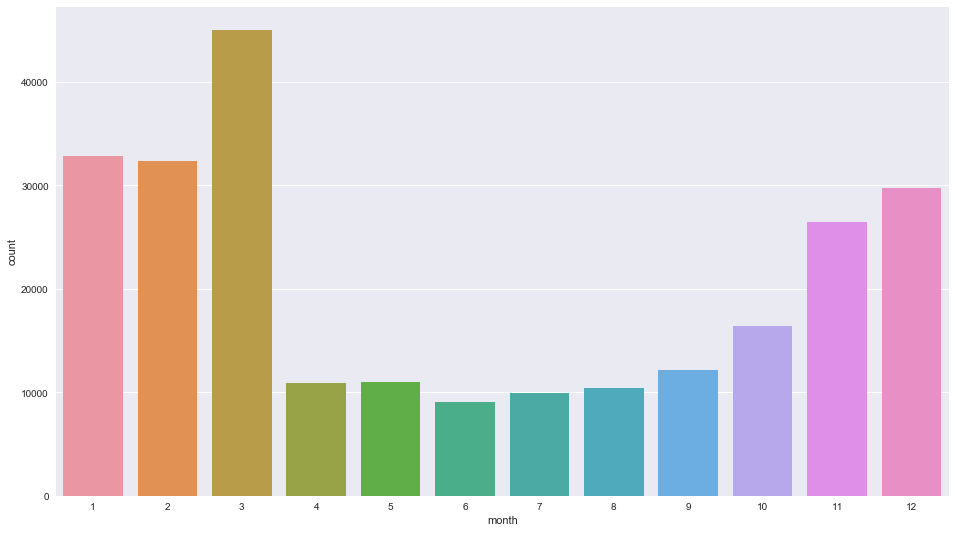

In [209]:
sns.countplot(x="month", data=all_tweets, orient='v');

In [210]:
#all_tweets.head(2)

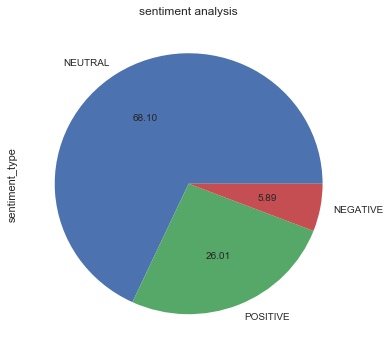

In [211]:
plt.rcParams["figure.figsize"] = [6,6]
all_tweets.sentiment_type.value_counts().plot(kind='pie',autopct='%.2f',title="sentiment analysis");


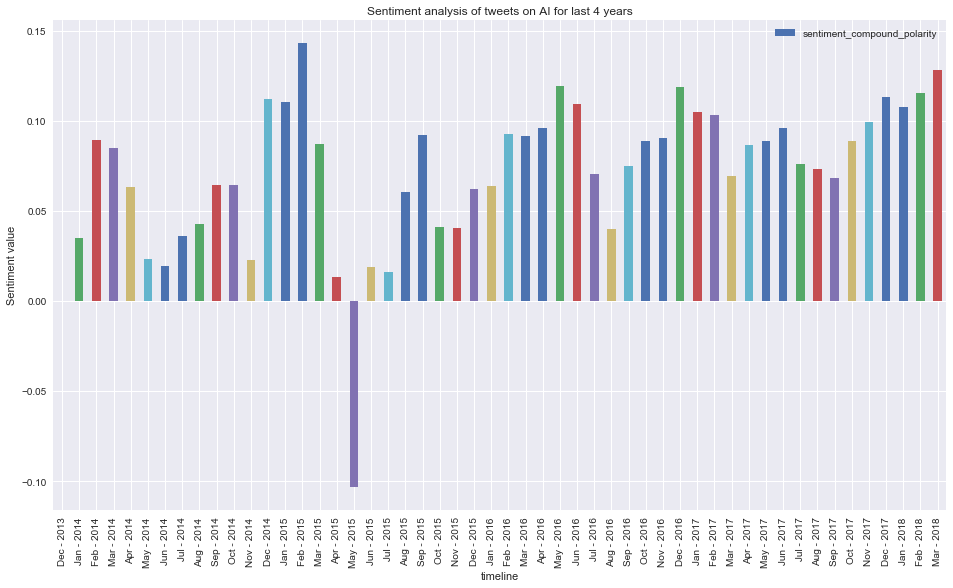

In [213]:

plt.rcParams["figure.figsize"] = [16,9]

#for i in top_Industries:
#    df = all_tweets[all_tweets.Industry_index == i].groupby(['month','year', 'month_name'],as_index=False).sentiment_compound_polarity.mean()
df = all_tweets.groupby(['month','year', 'month_name'],as_index=False).sentiment_compound_polarity.mean()
if len(df.index) > 1:
    df = df.sort_values(['year','month'])
    ax = df.sentiment_compound_polarity.plot(kind='bar', legend=True, rot = 90);
    ax.set_title("Sentiment analysis of tweets on AI for last 4 years")
    ax.set_xlabel('timeline')
    ax.set_ylabel('Sentiment value')
    ax.set_xticklabels(df['month_name'].str.cat(df['year'].values.astype(str), sep=' - '));
    plt.show()


In [214]:

df1 = all_tweets.groupby(['month','year', 'month_name'],as_index=False).id.count()
df1 = df1.sort_values(['year','month'])
df1.head(2)

,month,year,month_name,id
47,12,2013,Dec,2
0,1,2014,Jan,78


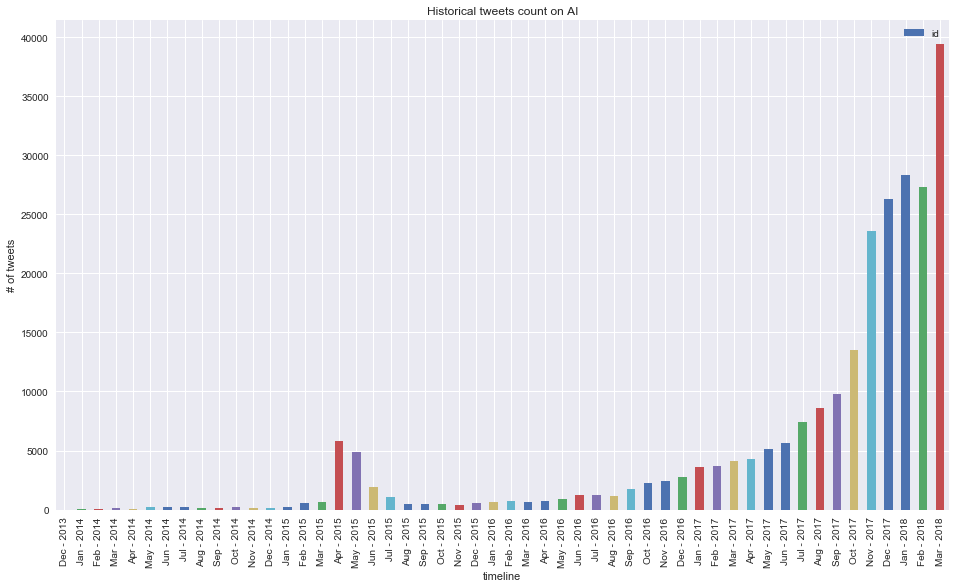

In [215]:
plt.rcParams["figure.figsize"] = [16,9]

ax = df1.id.plot(kind='bar', legend=True, rot = 90);
ax.set_title('Historical tweets count on AI')

ax.set_xlabel('timeline')
ax.set_ylabel('# of tweets')
ax.set_xticklabels(df1['month_name'].str.cat(df1['year'].values.astype(str), sep=' - '));

In [221]:
clean_text = all_tweets.clean_text.str.cat(sep=' ')

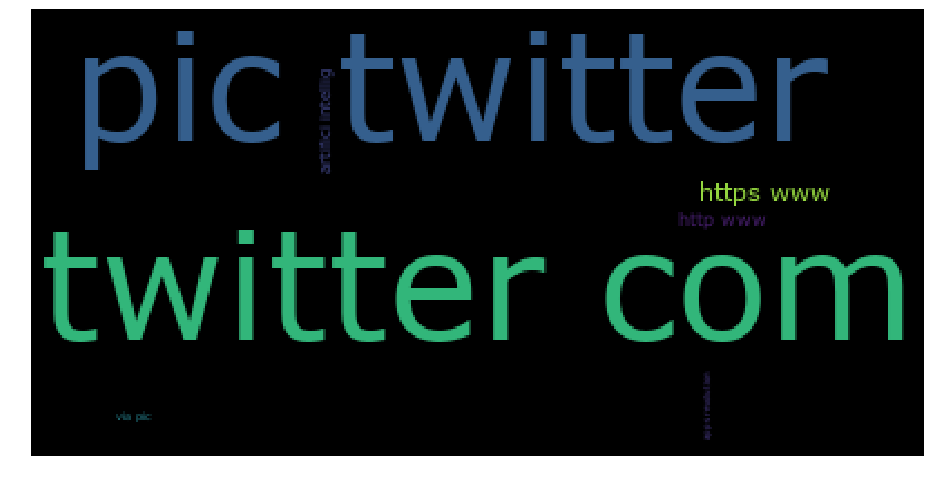

In [222]:
# Simple WordCloud

plt.rcParams["figure.figsize"] = [16,9]

wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                      relative_scaling = 1.0,
                      stopwords = set(stopwords.words("english")) # set or space-separated string
                      , scale=1
                      ).generate(clean_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
#df.plot.pie(subplots=True,figsize=(8, 3))